# ODE NHP Sequence Prediction Test

Test ODE-GRU network with NHP loss on synthetic data

In [1]:
import math
import numpy as np
import torch
import hotpp
import seaborn as sns
from hotpp.data import PaddedBatch
from matplotlib import pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

Synthetic dataset with a predefined distribution of time delta.

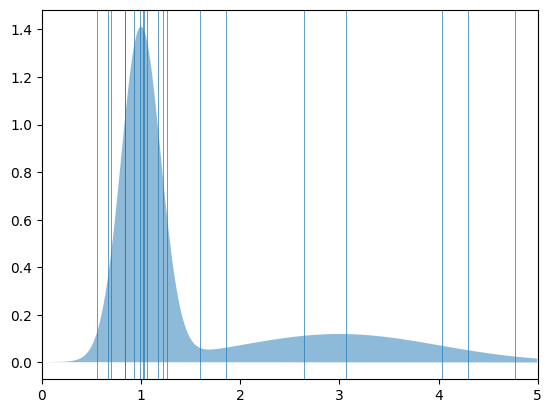

In [2]:
class DTDistribution:
    def __init__(self, label=0):
        if label == 0:
            self.means = torch.tensor([1, 3]).float()
            self.stds = torch.tensor([0.2, 1])
            self.probs = torch.tensor([0.7, 0.3])
        elif label == 1:
            self.means = torch.tensor([2]).float()
            self.stds = torch.tensor([0.5])
            self.probs = torch.tensor([1.0])
        else:
            raise NotImplementedError(label)

    @property
    def entropy(self):
        n = 10000
        s = self.sample(10000)
        return -self.log_pdf(s).mean()

    @property
    def expectation(self):
        return (self.means * self.probs).sum()

    def log_pdf(self, dt):
        nc = len(self.means)
        shape = [nc] + [1] * dt.ndim
        means = self.means.reshape(*shape)
        stds = self.stds.reshape(*shape)
        probs = self.probs.reshape(*shape)
        log_pdfs = -0.5 * (2 * math.pi * stds ** 2).log() - (means - dt) ** 2 / 2 / stds ** 2
        return torch.logsumexp(log_pdfs + probs.log(), 0)

    def sample(self, size):
        components = torch.multinomial(self.probs, size, replacement=True)  # S.
        sample = (torch.randn(size, 1) * self.stds + self.means).take_along_dim(components[:, None], 1).squeeze(1)
        return sample.clip(min=0)

    def plot(self, sample_size=20, ax=None):
        if ax is None:
            ax = plt.gca()
        x_min = 0
        x_max = self.means.max().item() + self.stds.max().item() * 2
        ax.set_xlim(x_min, x_max)
        if sample_size:
            sample = self.sample(sample_size)
            for x in sample:
                ax.axvline(x, 0, 1, linewidth=0.5)

        xs = torch.linspace(x_min, x_max, 1000)
        pdfs = self.log_pdf(xs).exp()
        # Fix filling.
        xs[-1] = xs[-2]
        pdfs[-1] = 0
        ax.fill(xs, pdfs, alpha=0.5)

DTDistribution().plot()

**Create batch**

Each sequences is composed of two timestamps: 0 and sampled. All labels are identical.

In [3]:
batch_size = 1000
sample_size = 10
prefetch_factor = 10  # Sample more data to prevent time delta distortions after sorting.
num_labels = 2

time_deltas = torch.stack([DTDistribution(label).sample(batch_size * sample_size * prefetch_factor).reshape(batch_size, sample_size * prefetch_factor)
                           for label in range(num_labels)], 1)  # (B, N, S).
timestamps = time_deltas.cumsum(-1).flatten(1, 2)  # (B, L).
labels = torch.cat([torch.full([batch_size, sample_size * prefetch_factor], label, dtype=torch.long)
                    for label in range(num_labels)], 1)  # (B, L).
timestamps, order = timestamps.sort(dim=1)
labels = labels.take_along_dim(order, 1)

# Drop tails to suppress time delta distortions after sorting.
timestamps = timestamps[:, :sample_size * num_labels]
labels = labels[:, :sample_size * num_labels]

batch = PaddedBatch(
    {
        "timestamps": timestamps,  # (B, L).
        "labels": labels  # (B, L).
    },
    torch.full([batch_size], sample_size * num_labels)
)
print(batch.shape)

torch.Size([1000, 20])


# Model

In [6]:
module = hotpp.modules.NextItemModule(
    seq_encoder=hotpp.nn.RnnEncoder(
        embeddings={"labels": {"in": num_labels, "out": 16}},
        rnn_partial=lambda dim: hotpp.nn.ODEGRU(dim, 16, num_diff_layers=3),
    ),
    head_partial=lambda idim, odim: hotpp.nn.Head(idim, odim, hidden_dims=[16]),
    loss=hotpp.losses.NHPLoss(num_labels, thinning_params={"max_delta": 5, "max_steps": 100}),
    optimizer_partial=lambda p: torch.optim.Adam(p, lr=0.001)
)
module = module.to(DEVICE).eval()
batch = batch.to(DEVICE)

# Train

In [7]:
entropy = np.mean([DTDistribution(label).entropy.item() for label in range(num_labels)])
print(f"Mean entropy (minimum expected loss): {entropy:.3f}")

module.train()
optimizer = module.configure_optimizers()
for step in range(2000):
    loss = module.training_step((batch, None), None)
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(module.parameters(), 1)
    if step % 200 == 0:
        print(f"Step {step}, Loss {loss.item():.2f}, Grad {grad_norm.item():.2f}")
    optimizer.step()
module.eval()
pass

Mean entropy (minimum expected loss): 0.772


/home/ivan/.venv/esp/lib/python3.12/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Step 0, Loss 1.68, Grad 0.61
Step 200, Loss 1.03, Grad 0.09
Step 400, Loss 0.83, Grad 0.07
Step 600, Loss 0.79, Grad 0.05
Step 800, Loss 0.78, Grad 0.17
Step 1000, Loss 0.78, Grad 0.08
Step 1200, Loss 0.77, Grad 0.14
Step 1400, Loss 0.77, Grad 0.16
Step 1600, Loss 0.77, Grad 0.21
Step 1800, Loss 0.76, Grad 0.36


# Test generation

In [11]:
sample_size = 100
gen_times = torch.rand(sample_size * num_labels)
gen_labels = (torch.zeros(1, sample_size, dtype=torch.long) + torch.arange(num_labels)[:, None]).flatten()
gen_prefixes = PaddedBatch({"timestamps": gen_times[:, None],
                            "labels": gen_labels[:, None]},
                            torch.ones(len(gen_times), dtype=torch.long)).to(DEVICE)
indices = PaddedBatch(torch.zeros(len(gen_prefixes), 1, dtype=torch.long),
                      torch.ones(len(gen_prefixes), dtype=torch.long)).to(DEVICE)

module._loss._thinning_params["max_steps"] = 100
module._loss._prediction = "sample"
try:
    with torch.no_grad():
        sequences = module.generate_sequences(gen_prefixes, indices, 100)
finally:
    module._loss._thinning_params["max_steps"] = 10000
    module._loss._prediction = "mean"
print(sequences.payload["timestamps"].shape)

torch.Size([200, 1, 100])


In [12]:
counts = batch.payload["labels"].flatten().bincount()
print("Labels priors:", counts / counts.sum())
counts = sequences.payload["labels"].flatten().bincount()
print("Output label probs:", counts / counts.sum())

Labels priors: tensor([0.5613, 0.4387], device='cuda:0')
Output label probs: tensor([0.5530, 0.4469], device='cuda:0')


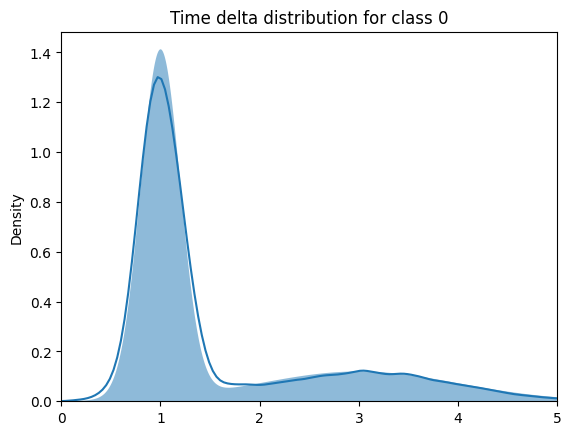

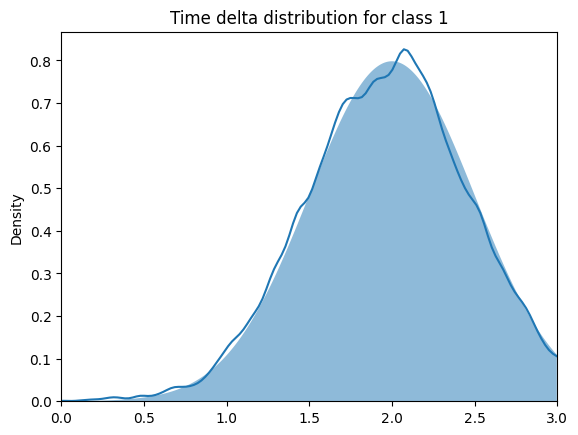

In [13]:
timestamps = sequences.payload["timestamps"].squeeze().cpu()
labels = sequences.payload["labels"].squeeze().cpu()
for label in range(num_labels):
    mask = labels == label
    deltas = torch.cat([
        ts[m][1:] - ts[m][:-1]
        for ts, m in zip(timestamps, mask)
    ])
    DTDistribution(label).plot(None)
    sns.kdeplot(deltas, label=label, bw_adjust=.5)
    plt.title(f"Time delta distribution for class {label}")
    plt.show()